# Holography Simulator

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.restoration import unwrap_phase, richardson_lucy

from libertem.utils.generate import hologram_frame
from libertem.io.dataset.memory import MemoryDataSet
from libertem.udf.holography import HoloReconstructUDF
from libertem.api import Context

import hyperspy.api as hs
from holospy.reconstruct import (
    estimate_sideband_position,
    estimate_sideband_size,
    reconstruct,
)
from scipy.signal import convolve2d, convolve
from scipy.fft import fft2, ifft2, fftfreq
from scipy.optimize import minimize

In [2]:
# Setup context
ctx = Context()

In [106]:
# Define grid
sx, sy = (256, 256)
mx, my = np.meshgrid(np.arange(sx), np.arange(sy))
# Define sphere region
sphere = (mx - 33.)**2 + (my - 103.)**2 < 20.**2
# Calculate long-range contribution to the phase
phase = ((mx - 33.)**2 + (my - 103.)**2) / sx / 40.
# Add mean inner potential contribution to the phase
phase[sphere] += (-((mx[sphere] - 33.)**2 + (my[sphere] - 103.)**2) / sx / 3 + 0.5) * 2.
# Calculate amplitude of the phase
amp = np.ones_like(phase)
amp[sphere] = ((mx[sphere] - 33.)**2 + (my[sphere] - 103.)**2) / sx / 3 + 0.5


In [107]:
np.load('k3.npz').files

['psf']

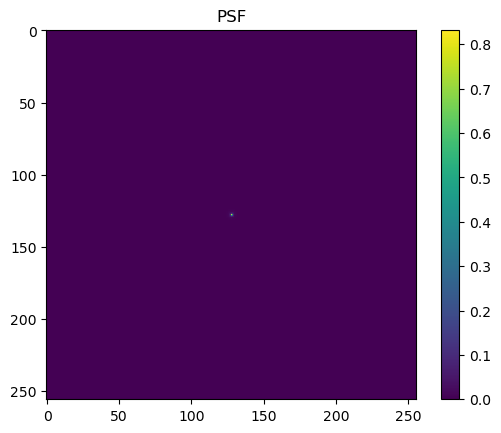

In [108]:
# full_psf = np.load('UltraScan1000FT.npz')['arr_0']
full_psf = np.load('k3.npz')['psf']
plt.figure()
plt.title('PSF')
plt.imshow(full_psf)
plt.colorbar()
plt.show()

In [109]:
# Apply the PSF to the amplitude
amp_filtered = convolve2d(amp, full_psf, mode='same', boundary='symm')
# Apply the PSF to phase
phase_filtered = convolve2d(phase, full_psf, mode='same', boundary='symm')

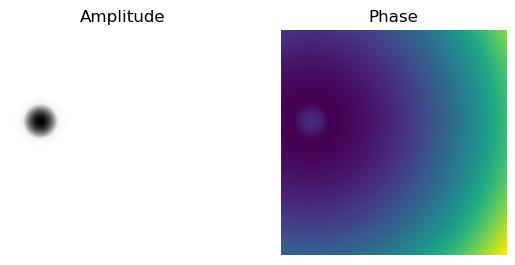

In [110]:
# Plot
f, axs = plt.subplots(1, 2)
axs[0].imshow(amp_filtered, cmap='gray')
axs[0].title.set_text('Amplitude')
axs[0].set_axis_off()
axs[1].imshow(phase_filtered, cmap='viridis')
axs[1].title.set_text('Phase')
axs[1].set_axis_off()
plt.show()

In [111]:
amp = amp_filtered
phase = phase_filtered

Compute holograms

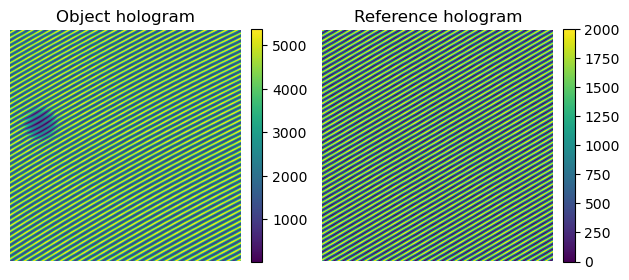

In [151]:
## Noiseless hologram
holo = hologram_frame(amp, phase)
ref = hologram_frame(np.ones_like(phase), np.zeros_like(phase))

# Plot
cmap = 'viridis'
f, axs = plt.subplots(1, 2)
im1 = axs[0].imshow(holo, cmap=cmap)
axs[0].title.set_text('Object hologram')
axs[0].set_axis_off()
cbar1 = f.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)

im2 = axs[1].imshow(ref, cmap=cmap)
axs[1].title.set_text('Reference hologram')
axs[1].set_axis_off()
cbar2 = f.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

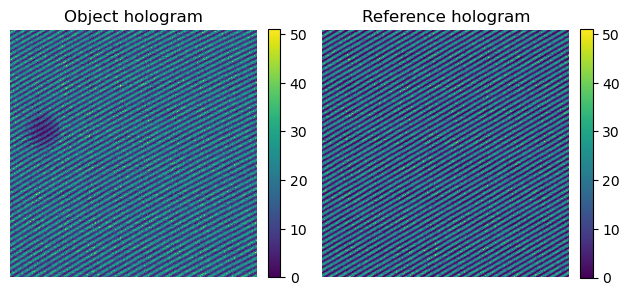

In [165]:
holo = hologram_frame(amp, phase)
holo = holo / holo.max()
ref = hologram_frame(np.ones_like(phase), np.zeros_like(phase))
ref = ref / ref.max()


holo_poisson = np.random.poisson(30.0*holo) 
ref_poisson = np.random.poisson(30.0*ref) 

# #optional:
# holo_poisson = hologram_frame(amp, phase, poisson_noise=True)
# ref_poisson = hologram_frame(np.ones_like(phase), np.zeros_like(phase), poisson_noise=True)


# Plot
cmap = 'viridis'
f, axs = plt.subplots(1, 2)
im1 = axs[0].imshow(holo_poisson, cmap=cmap)
axs[0].title.set_text('Object hologram')
axs[0].set_axis_off()
cbar1 = f.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)

im2 = axs[1].imshow(ref_poisson, cmap=cmap)
axs[1].title.set_text('Reference hologram')
axs[1].set_axis_off()
cbar2 = f.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


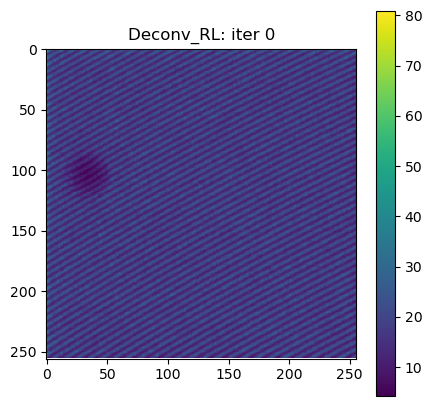

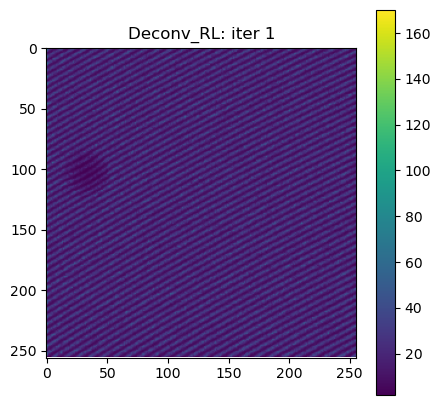

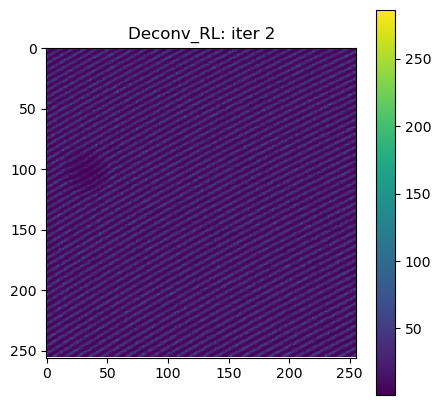

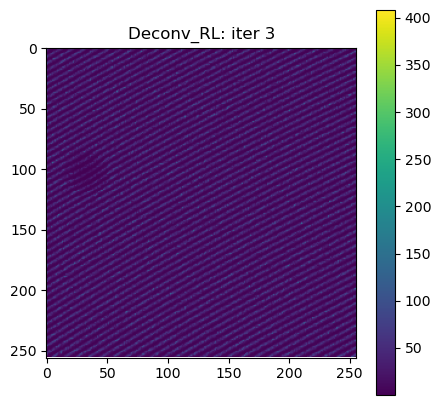

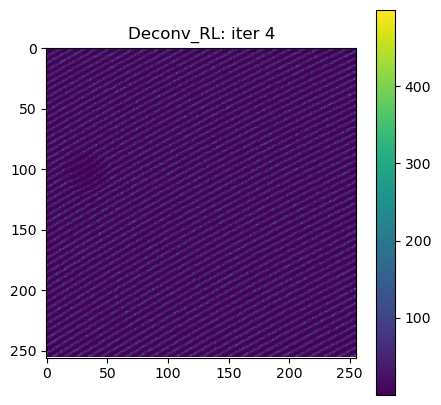

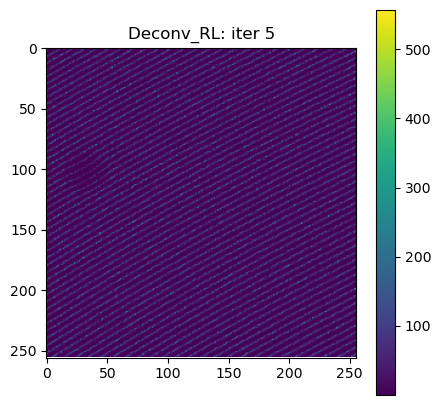

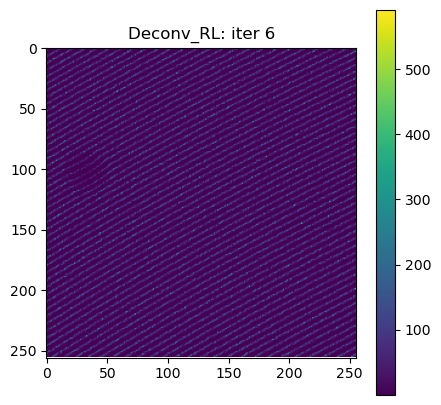

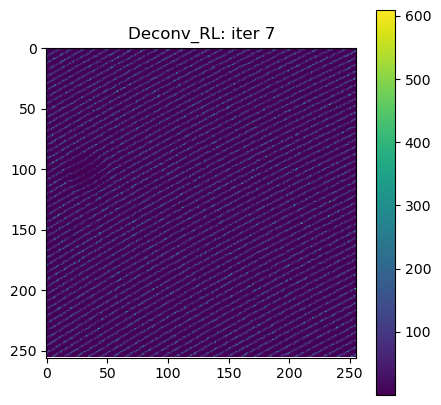

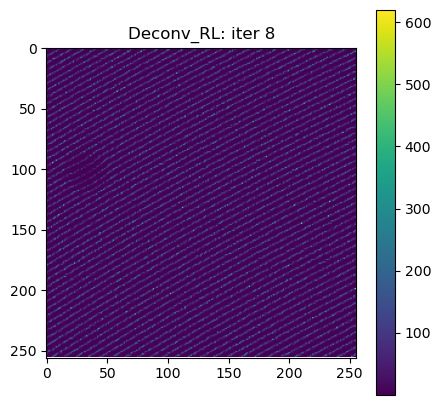

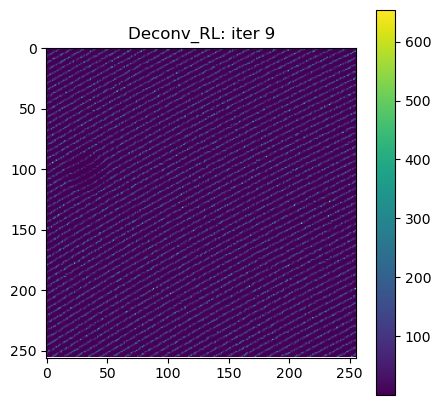

In [166]:
def total_variation(image):
    # Get image dimensions
    h, w = image.shape

    # Frequencies for the Fourier domain
    fx = fftfreq(w).reshape(1, -1)  # Frequency in x (row vector)
    fy = fftfreq(h).reshape(-1, 1)  # Frequency in y (column vector)

    # Compute the Fourier transform of the image
    image_fft = fft2(image)

    # Compute derivatives in the Fourier domain
    dx_fft = 1j * 2 * np.pi * fx * image_fft  # Derivative w.r.t. x
    dy_fft = 1j * 2 * np.pi * fy * image_fft  # Derivative w.r.t. y

    # Transform back to the spatial domain
    dx = np.abs(ifft2(dx_fft))
    dy = np.abs(ifft2(dy_fft))

    # Compute the total variation as the sum of gradient magnitudes
    tv = np.sum(np.sqrt(dx**2 + dy**2))

    return tv

def l1_norm(image):
    return np.sum(np.abs(image))

def my_richardson_lucy_with_regularization(image, psf, num_iter=5, filter_eps = 1e-12, tv = True, tv_weight=0.01, l1 = True, l1_weight=0.01, display=False):
    float_type = np.result_type(image, psf, np.float32)
    image = image.astype(float_type, copy=False)
    psf = psf.astype(float_type, copy=False)
    im_deconv = np.full(image.shape, 0.5, dtype=float_type)
    psf_mirror = np.flip(psf)
    # Small regularization parameter used to avoid 0 divisions
    eps = 1e-12
    for i in range(num_iter):
        conv = convolve(im_deconv, psf, mode='same') + eps
        relative_blur = np.where(conv < filter_eps, 0, image / conv)
        im_deconv *= convolve(relative_blur, psf_mirror, mode='same')
        if display:
            plt.figure(figsize = (5,5))
            plt.title(f'Deconv_RL: iter {i}')
            plt.imshow(im_deconv)
            plt.colorbar()
            plt.show()
    # # use scipy minimize to optimize the TV norm and L1 norm
    # tv_weight = tv_weight if tv else 1e-12
    # l1_weight = l1_weight if l1 else 1e-12
    # def objective(x):
    #     x = x.reshape(im_deconv.shape)
    #     return l1_weight * l1_norm(x) + tv_weight * total_variation(x) + np.sum((x - im_deconv)**2)
    # res = minimize(objective, im_deconv.flatten())
    return im_deconv
    # return res.x

n_iter = 10
im_deblur_holo = my_richardson_lucy_with_regularization(holo_poisson, full_psf, num_iter=n_iter, display=True)
im_deblur_ref = ref_poisson

In [167]:
im_deblur_holo.max()

np.float64(653.8812222906245)

In [168]:
holo = holo_poisson
ref = ref_poisson

In [169]:
holo = im_deblur_holo
ref = im_deblur_ref

In [170]:
# n_iter = 10
# im_deblur_holo = richardson_lucy(holo_poisson / holo_poisson.max(), full_psf, num_iter=n_iter)
# # im_deblur_ref = richardson_lucy(ref / ref.max(), full_psf, num_iter=n_iter)
# im_deblur_ref = ref
# print(im_deblur_holo.max(), im_deblur_holo.min())
# # Plot
# # f, axs = plt.subplots(1, 2)
# # axs[0].imshow(im_deblur_holo, cmap='gray')
# # axs[0].title.set_text('Object hologram')
# # axs[0].set_axis_off()
# # axs[1].imshow(im_deblur_ref, cmap='gray')
# # axs[1].title.set_text('Reference hologram')
# # axs[1].set_axis_off()

# plt.figure()
# plt.imshow(im_deblur_holo)
# plt.colorbar()
# plt.show()


In [171]:
# n_iters = np.arange(1,20)
# losses = np.zeros_like(n_iters, dtype=float)
# for i, n_iter in enumerate(n_iters):
#     im_deblur_holo = richardson_lucy(holo_poisson / holo_poisson.max(), full_psf, num_iter=n_iter)
#     # im_deblur_ref = richardson_lucy(ref / ref.max(), full_psf, num_iter=n_iter)
#     losses[i] = np.mean((im_deblur_holo - holo / holo.max())**2)
# plt.figure()
# plt.plot(n_iters, losses)
# plt.xlabel('Number of iterations')
# plt.ylabel('Loss')
# plt.title('Richardson-Lucy deconvolution')
# plt.show()

In [172]:
holo = im_deblur_holo
ref = im_deblur_ref

In [173]:
holo = holo_poisson
ref = ref_poisson

Compute reconstruction

In [174]:
dataset_holo = MemoryDataSet(data=holo.reshape((1, sx, sy)), tileshape=(1, sx, sy), num_partitions=1, sig_dims=2)
dataset_ref = MemoryDataSet(data=ref.reshape((1, sx, sy)), tileshape=(1, sx, sy), num_partitions=1, sig_dims=2)

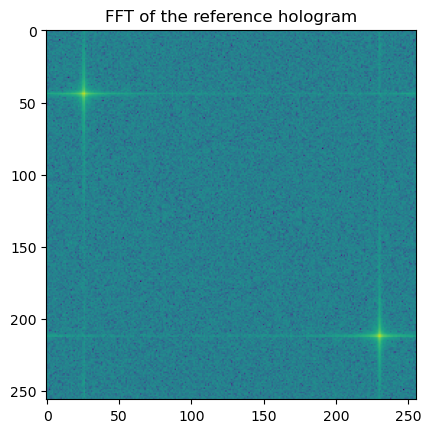

In [175]:
plt.imshow(np.log(np.abs(np.fft.fft2(ref))))
plt.title('FFT of the reference hologram')
plt.show()

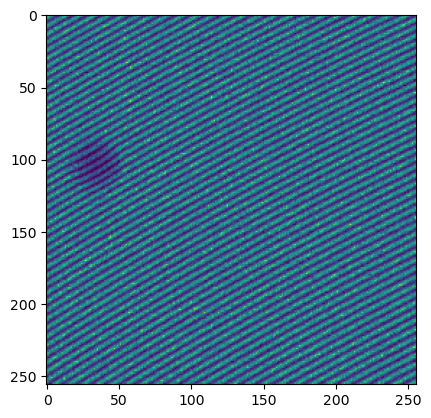

In [176]:
plt.imshow(holo)
plt.show()

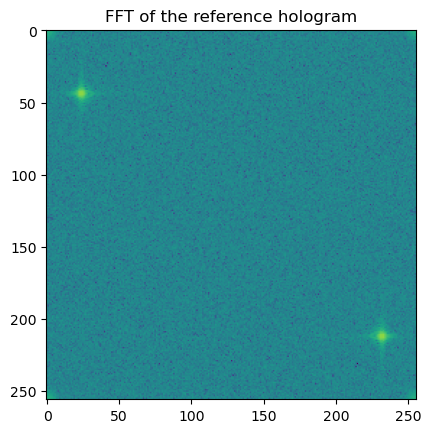

In [177]:
plt.imshow(np.log(np.abs(np.fft.fft2(holo))))
# print(np.fft.fftfreq(holo.shape[0]));

plt.title('FFT of the reference hologram')
plt.show()

In [178]:
# Store the hologram in a Singal2D to estimate the sideband position and size
holo_signal2d = hs.signals.Signal2D(ref)
holo_signal2d.set_signal_type("hologram")

sb_position = holo_signal2d.estimate_sideband_position(ap_cb_radius=None, sb='lower')
sb_size = holo_signal2d.estimate_sideband_size(sb_position)

sb_position = sb_position.data
sb_size = sb_size.data[0]

print(sb_position)
print(sb_size)

[44 26]
25.553864678361276


In [179]:
# Define output shape
output_shape = (int(sb_size * 2), int(sb_size * 2))

# Create reconstruction UDF:
holo_udf = HoloReconstructUDF(out_shape=output_shape,
                              sb_position=sb_position,
                              sb_size=sb_size)

# Reconstruct holograms, access data directly
w_holo = ctx.run_udf(dataset=dataset_holo, udf=holo_udf)['wave'].data
w_ref = ctx.run_udf(dataset=dataset_ref, udf=holo_udf)['wave'].data

In [180]:
w_holo

array([[[-156.45842093 +46.13223051j, -145.77549337 +70.82155121j,
         -150.42664792 +63.85268238j, ...,  -59.89638406+140.32297163j,
         -132.44477197+130.88430338j, -158.44682607 +53.03602586j],
        [-139.1038201 +105.17180061j,  -82.94703433+118.88370525j,
          -96.90094843+127.20212786j, ...,   21.99425144+139.15194225j,
          -53.49644025+170.66819084j, -126.75816295+113.44385946j],
        [ -95.90428844+122.27857155j,  -72.29937741+140.86755642j,
          -92.80241569+153.48275922j, ...,   82.96978956+133.06746363j,
          -17.65776198+177.03238465j,  -92.9231234 +126.17257986j],
        ...,
        [-142.88232625 +75.55989452j, -119.03946262+162.09447088j,
         -105.71896665+133.54406628j, ...,    8.50456699+148.68301627j,
          -67.48442856+162.7534614j , -136.12100198 +63.98440119j],
        [-142.80791816 +51.82731342j, -142.31613118 +89.1755421j ,
         -135.36623927 +62.51405566j, ...,   13.05852967+148.52688546j,
          -80.554588

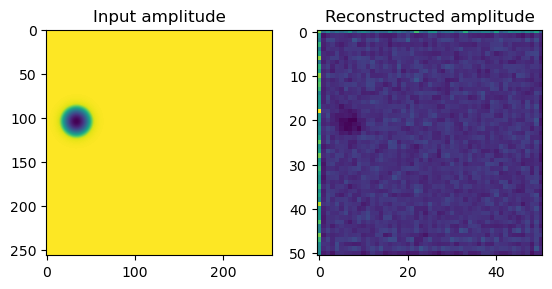

In [181]:
# Correct object wave using reference wave
w = w_holo / w_ref

# Calculate plot phase shift and amplitude
amp_r = np.abs(w)
phase_r = np.angle(w)

# Plot amplitude
f, ax = plt.subplots(1, 2)
ax[0].imshow(amp)
ax[0].title.set_text('Input amplitude')
ax[1].imshow(amp_r[0])
ax[1].title.set_text('Reconstructed amplitude')


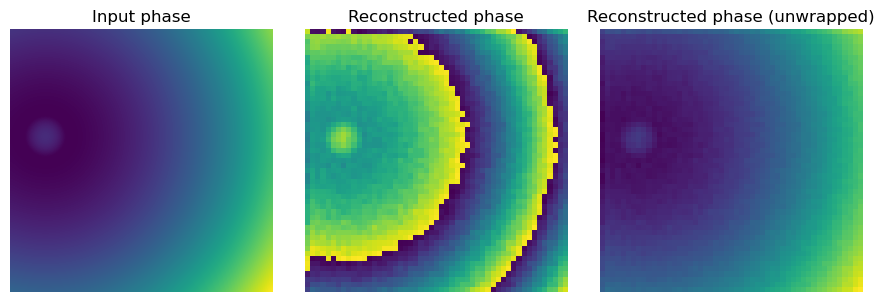

In [182]:
# Unwrap phase:
phase_unwrapped = unwrap_phase(phase_r[0])

# Plot
f, axs = plt.subplots(1, 3, figsize=(9, 3))
axs[0].imshow(phase, cmap='viridis')
axs[0].title.set_text('Input phase')
axs[0].set_axis_off()
axs[1].imshow(phase_r[0])
axs[1].title.set_text('Reconstructed phase')
axs[1].set_axis_off()
axs[2].imshow(phase_unwrapped, cmap='viridis')
axs[2].title.set_text('Reconstructed phase (unwrapped)')
axs[2].set_axis_off()

plt.tight_layout()
plt.show()

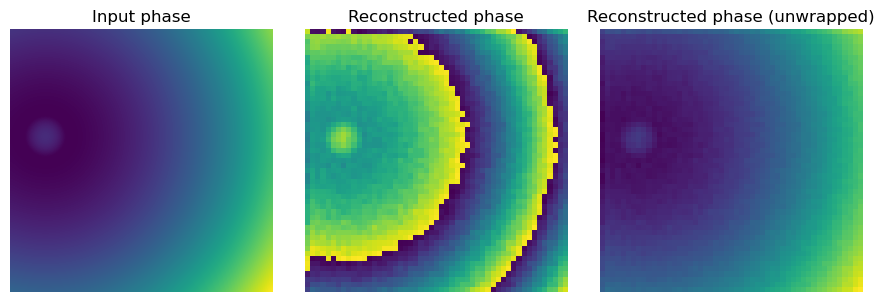

In [183]:
# Unwrap phase:
phase_unwrapped = unwrap_phase(phase_r[0])

# Plot
f, axs = plt.subplots(1, 3, figsize=(9, 3))
axs[0].imshow(phase, cmap='viridis')
axs[0].title.set_text('Input phase')
axs[0].set_axis_off()
axs[1].imshow(phase_r[0])
axs[1].title.set_text('Reconstructed phase')
axs[1].set_axis_off()
axs[2].imshow(phase_unwrapped, cmap='viridis')
axs[2].title.set_text('Reconstructed phase (unwrapped)')
axs[2].set_axis_off()

plt.tight_layout()
plt.show()

In [184]:
ctx.close()